In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy as sp
from scipy import stats
import pickle
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error 

## Utility Functions

In [19]:
def Examine_Nulls(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    return missing_value_df

In [20]:
def Save_Var(data, save_name):
    with open(str(save_name + ".data"), 'wb') as f:
        pickle.dump(data, f)
        
    try:
        with open(str(save_name + ".data"), 'rb') as f:
            new_data = pickle.load(f)
    except:
        print("Error: saving not successful")
    else:
        print(str(save_name + ".data" + " saved succesfully"))

def Load_Var(save_name):
    with open(save_name, 'rb') as f:
        data = pickle.load(f)
    return data 

## Load and Process Data

In [21]:
merged_df_ = pd.read_csv("C:\\Users\\quintoj\\Desktop\\AHCCD_Combined\\Data\\ahccd_combined_w_metadata.csv", index_col=['Station','Longitude (Decimal Degrees)', 'Latitude (Decimal Degrees)', 'Prov', 'Date'])
merged_df_ = merged_df_.drop('Unnamed: 0', axis=1)
merged_df_.reset_index(inplace=True)
merged_df_['Station'] = merged_df_['Station'].astype(str)

C:\Users\quintoj\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\quintoj\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [22]:
np.unique(merged_df_['Station']).shape

(323,)

In [23]:
# merged_df_['Date'] = pd.to_datetime(merged_df_['Date'])
# merged_df_ = merged_df_[merged_df_['Date'].dt.year >= 2000]

In [24]:
merged_df_ = merged_df_.set_index(['Station','Longitude (Decimal Degrees)', 'Latitude (Decimal Degrees)', 'Prov', 'Date'])
merged_df = merged_df_[['Min_Temp', 'Max_Temp', 'Mean_Temp', 'snow_frac']]

In [25]:
merged_df

Min_Temp  \
Station Longitude (Decimal Degrees) Latitude (Decimal Degrees) Prov Date                   
1012010 -123.56                     48.71                      BC   1913-10-03       6.7   
                                                                    1913-10-04       4.5   
                                                                    1913-10-07       7.3   
                                                                    1913-10-09       1.4   
                                                                    1913-10-10       2.7   
...                                                                                  ...   
709CEE9 -78.28                      48.80                      QUE  2015-11-06       0.5   
                                                                    2015-11-19       4.5   
                                                                    2015-11-21      -7.0   
                                                                    2015-11-24     -20.5   
                                                                    2015-11-28     -18.5   

                                                                                Max_Temp  \
Station Longitude (Decimal Degrees) Latitude (Decimal Degrees) Prov Date                   
1012010 -123.56                     48.71                      BC   1913-10-03      15.2   
                                                                    1913-10-04      12.2   
                                                                    1913-10-07       5.3   
                                                                    1913-10-09      10.1   
                                                                    1913-10-10      10.6   
...                                                                                  ...   
709CEE9 -78.28                      48.80                      QUE  2015-11-06      14.0   
                                                                    2015-11-19      13.0   
                                                                    2015-11-21      -1.0   
                                                                    2015-11-24      -3.5   
                                                                    2015-11-28      -7.0   

                                                                                Mean_Temp  \
Station Longitude (Decimal Degrees) Latitude (Decimal Degrees) Prov Date                    
1012010 -123.56                     48.71                      BC   1913-10-03       11.0   
                                                                    1913-10-04        8.4   
                                                                    1913-10-07        6.3   
                                                                    1913-10-09        5.8   
                                                                    1913-10-10        6.7   
...                                                                                   ...   
709CEE9 -78.28                      48.80                      QUE  2015-11-06        7.3   
                                                                    2015-11-19        8.8   
                                                                    2015-11-21       -4.0   
                                                                    2015-11-24      -12.0   
                                                                    2015-11-28      -12.8   

                                                                                snow_frac  
Station Longitude (Decimal Degrees) Latitude (Decimal Degrees) Prov Date                   
1012010 -123.56                     48.71                      BC   1913-10-03    0.00000  
                                                                    1913-10-04    0.00000  
                                                                    1913-10-07    0.00000  
                

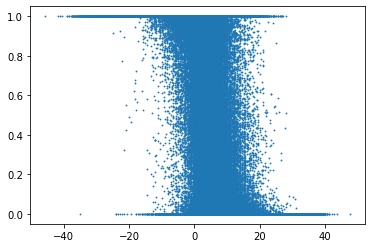

In [26]:
plt.scatter(merged_df['Max_Temp'], merged_df['snow_frac'], s=0.7)

## Linear Interpolation

In [27]:
from sklearn.isotonic import IsotonicRegression 

In [28]:
ir_era5 = Load_Var('Data_Files/iso_t2m.data')

C:\Users\quintoj\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator IsotonicRegression from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [29]:
def Heaviside(x, a ,b, c): 
    return a * (np.sign(x - b) + c) # Heaviside function

In [30]:
t2m_thresh = 1.0116516113281477

In [31]:
def logistic4(x, k, mu):
    a = 1 
    c = 0
    return a + (c-a)/(1+np.exp(-k*(x-mu))) 

In [32]:
def RMSE(calculate_error, yData, resid=None, yPred=None, params=None):
    if calculate_error is False and resid is not None:
        SE = np.square(resid) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(resid) / np.var(yData))
    elif calculate_error is True and yPred is not None:
        resid = yData - yPred
        SE = np.square(resid) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(resid) / np.var(yData))
    if params is not None:
        print('Parameters:', params)
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

In [33]:
params_era5 = [1.36527176, 0.98420547]

In [212]:
# preds_log = []
# preds_iso = []
# preds_heav = []
# for i, j in zip(merged_df['Min_Temp'], merged_df['Max_Temp']):
#     vals = np.linspace(i, j, 100)
#     preds_log.append(
#         np.mean(logistic4(vals, *params_era5))
#     )
#     preds_iso.append(
#         np.mean(ir_era5.predict(vals))
#     )
#     preds_heav.append(
#         np.mean(Heaviside(vals, -0.5, t2m_thresh, -1))
#     )

In [35]:
preds_iso = Load_Var('Data_Files/preds_iso.data')
preds_log = Load_Var('Data_Files/preds_log.data')

In [36]:
merged_df['preds_log'] = preds_log
merged_df['preds_iso'] = preds_iso

<ipython-input-36-905df1dc4498>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['preds_log'] = preds_log
<ipython-input-36-905df1dc4498>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['preds_iso'] = preds_iso


Text(0.5, 1.0, 'Generalized Logistic Regression')

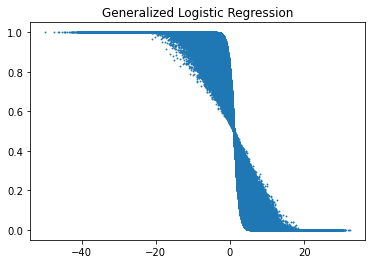

In [213]:
plt.scatter(merged_df['Mean_Temp'], preds_log, s=0.7)
plt.title("Generalized Logistic Regression")

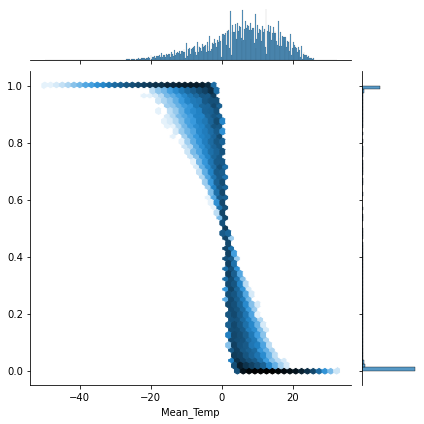

In [224]:
sns.jointplot(x=merged_df.Mean_Temp, y=preds_log, kind='hex', bins='log')

In [218]:
RMSE(calculate_error=True, yData=merged_df['snow_frac'], yPred=preds_log)

RMSE: 0.2044439416625395
R-squared: 0.7880977152240405


In [45]:
print("MAE:", mean_absolute_error(merged_df['snow_frac'], preds_log))

MAE: 0.0858316097065849


Text(0.5, 1.0, 'Isotonic Regression')

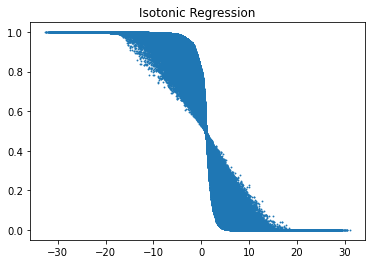

In [214]:
plt.scatter(merged_df['Mean_Temp'], preds_iso, s=0.7)
plt.title("Isotonic Regression")

In [225]:
RMSE(calculate_error=True, yData=merged_df['snow_frac'], yPred=preds_iso)

RMSE: 0.20335768929702883
R-squared: 0.7891574147090001


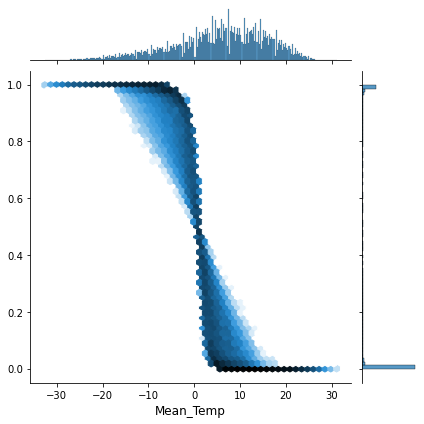

In [242]:
sns.jointplot(x=merged_df.Mean_Temp, y=preds_iso, kind='hex', bins='log')

In [219]:
RMSE(calculate_error=True, yData=merged_df['snow_frac'], yPred=preds_iso)

RMSE: 0.20335768929702883
R-squared: 0.7891574147090001


In [46]:
print("MAE:", mean_absolute_error(merged_df['snow_frac'], preds_log))

MAE: 0.0858316097065849


Text(0.5, 1.0, 'Heaviside Function')

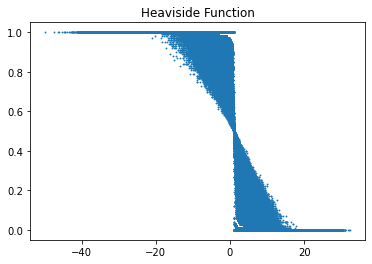

In [221]:
plt.scatter(merged_df['Mean_Temp'], preds_heav, s=0.7)
plt.title("Heaviside Function")

In [220]:
RMSE(calculate_error=True, yData=merged_df['snow_frac'], yPred=preds_heav)

RMSE: 0.20811225891023827
R-squared: 0.7799335417407872


## Univariate Modelling

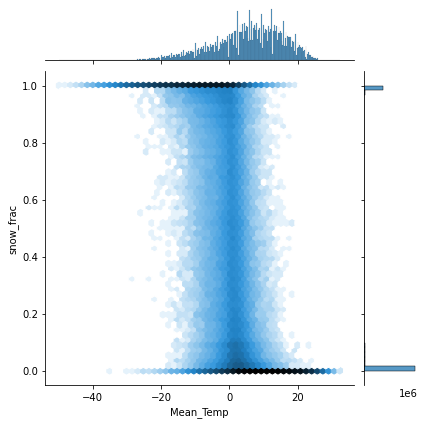

In [20]:
sns.jointplot(data=merged_df, x='Mean_Temp', y='snow_frac', kind='hex', bins='log')

<AxesSubplot:>

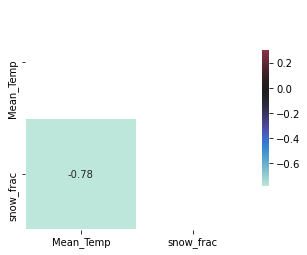

In [21]:
corr_matrix = merged_df.corr() 

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

## Logistic Curve Fitting

In [39]:
from scipy.optimize import curve_fit 

In [40]:
def logistic4(x, k, mu):
    a = 1 
    c = 0
    return a + (c-a)/(1+np.exp(-k*(x-mu))) 

In [41]:
def myfit(func, x, y):
    xr = x.ravel()
    yr = y.ravel()
    asort = np.argsort(xr)
    popt, pcov = curve_fit(func, xr[asort], yr[asort])
    res = yr[asort]-func(xr[asort], *popt)
    return popt, res # gives error b/w every pred and true point -> useful for validation -> MSE

In [42]:
def RMSE(calculate_error, yData, resid=None, yPred=None, params=None):
    if calculate_error is False and resid is not None:
        SE = np.square(resid) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(resid) / np.var(yData))
    elif calculate_error is True and yPred is not None:
        resid = yData - yPred
        SE = np.square(resid) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(resid) / np.var(yData))
    if params is not None:
        print('Parameters:', params)
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

In [30]:
x = merged_df['Mean_Temp']
y = merged_df['snow_frac']
x_lr = np.linspace(merged_df['Mean_Temp'].min(), merged_df['Mean_Temp'].max(), 1000)

In [31]:
params_log, resid_log = myfit(logistic4, x, y)

In [32]:
# For AHCCD
RMSE(params=params_log, calculate_error=False, yData=y, resid=resid_log) 

Parameters: [ 0.58729268 -0.06493154]
RMSE: 0.20242493693474778
R-squared: 0.7862400218365349


In [43]:
params_era5 = [1.36527176, 0.98420547]
y_log_era5 = logistic4(x, *params_era5)

NameError: name 'x' is not defined

In [62]:
# For ERA5-Land
RMSE(params=params_era5, calculate_error=True, yData=y, yPred=y_log_era5) 

Parameters: [1.36527176, 0.98420547]
RMSE: 0.21720632123018443
R-squared: 0.7575573610496775


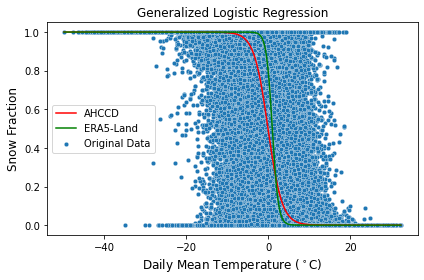

In [64]:
plt.scatter(x, y, marker='o', edgecolor='white', linewidth=0.3, label='Original Data', s=20)
plt.plot(x_lr, logistic4(x_lr, *params_log), color='red', label= 'AHCCD')
plt.plot(x_lr, logistic4(x_lr, *params_era5), color='green', label= 'ERA5-Land')
plt.xlabel('Daily Mean Temperature ($^\circ$C)')
plt.ylabel('Snow Fraction')
plt.title("Generalized Logistic Regression")
plt.legend(loc='center left')
plt.tight_layout()

## Isotonic Regression

In [34]:
from sklearn.isotonic import IsotonicRegression 

In [35]:
## For AHCCD
ir = IsotonicRegression(increasing=False).fit(x, y)
# Actual predictions
y_ir = ir.predict(x)
# For graphing
yy_ir = ir.predict(x_lr)

In [55]:
## For ERA5-Land
ir_era5 = Load_Var('iso_t2m.data')
y_ir_era5 = ir_era5.predict(x)
yy_ir_era5 = ir_era5.predict(x_lr)

Text(0.5, 1.0, 'Isotonic Regression')

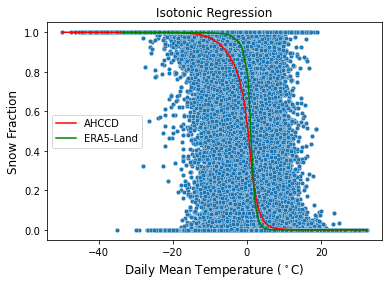

In [59]:
plt.scatter(x, y,  marker='o', edgecolor='white', linewidth=0.3, s=20)
plt.plot(x_lr, yy_ir, color='red', label='AHCCD')
plt.plot(x_lr, yy_ir_era5, color='green', label='ERA5-Land')
plt.xlabel('Daily Mean Temperature ($^\circ$C)')
plt.ylabel('Snow Fraction')
plt.legend()
plt.title('Isotonic Regression')

In [37]:
# For AHCCD
RMSE(calculate_error=True, yData=y, yPred=y_ir) 

RMSE: 0.20116272121522344
R-squared: 0.7886032872024724


In [57]:
# For ERA5-Land
RMSE(calculate_error=True, yData=y, yPred=y_ir_era5) 

RMSE: 0.21488610065637986
R-squared: 0.761807781859317


## Heaviside Function

In [38]:
# Make a dataframe of mean temp values and predicted values from isotonoic regression
iso_pts = pd.DataFrame(
    {"Mean_Temp": merged_df['Mean_Temp'],
     "snow_frac": y_ir}
)
iso_pts.reset_index(inplace=True)
iso_pts.drop(['Date', 'Station'], axis=1, inplace=True)

In [39]:
# Function to determine the mean temperature at which isotonic regression gives a value of 0.5
def find_neighbours(value, df, var):
    exactmatch=df[df.snow_frac==value]
    if exactmatch.empty is False:
        return exactmatch.index
    else:
        lowerneighbour_ind = df[df.snow_frac<value].snow_frac.idxmax()
        upperneighbour_ind = df[df.snow_frac>value].snow_frac.idxmin()
        
        lower_diff = np.abs(df.iloc[lowerneighbour_ind, :].snow_frac - 0.5)
        upper_diff = np.abs(df.iloc[upperneighbour_ind, :].snow_frac - 0.5)

        if lower_diff > upper_diff:
            return df.iloc[upperneighbour_ind, :][var]
        else:
            return df.iloc[lowerneighbour_ind, :][var]

In [40]:
thresh = find_neighbours(0.5, iso_pts, 'Mean_Temp')
print("Daily Mean Temp Threshold:", thresh) 

Daily Mean Temp Threshold: 0.3


In [41]:
def Heaviside(x, a ,b, c): 
    return a * (np.sign(x - b) + c) # Heaviside function

In [42]:
# For AHCCD
y_heaviside = Heaviside(x, -0.5, thresh, -1)
RMSE(calculate_error=True, yData=y, yPred=y_heaviside) 

RMSE: 0.23716958905817787
R-squared: 0.7062387350818087


In [51]:
# For ERA5-Land Data
t2m_thresh = 1.0116516113281477
y_heaviside_ = Heaviside(x, -0.5, t2m_thresh, -1)
RMSE(calculate_error=True, yData=y, yPred=y_heaviside_) 

RMSE: 0.24775886304152311
R-squared: 0.6832913943665115


Text(0.5, 1.0, 'Heaviside Function')

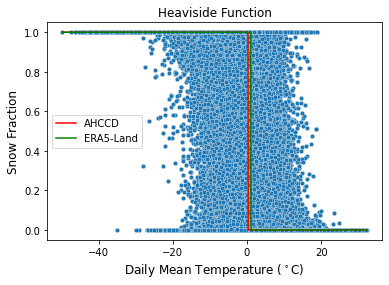

In [56]:
plt.scatter(x, y,  marker='o', edgecolor='white', linewidth=0.3, s=20)
plt.plot(x_lr, Heaviside(x_lr, -0.5, thresh, -1), c='r', label='AHCCD')
# Now plot heaviside fcn from ERA5-Land data
plt.plot(x_lr, Heaviside(x_lr, -0.5, t2m_thresh, -1), c='g', label="ERA5-Land")
plt.xlabel('Daily Mean Temperature ($^\circ$C)')
plt.ylabel('Snow Fraction')
plt.legend()
plt.title('Heaviside Function')

In [44]:
def Binned_Stats(df, variable, lower_temp, upper_temp, test_stat='mean', 
                 plot_histogram=False, interval=0.1, plot_bins=False):  
    # Define temperature bins
    values = np.arange(lower_temp, upper_temp, interval)
    values = [round(i, 1) for i in values]
    
    # Calculate bin statistics
    bin_stats, bin_edges, binnumber = stats.binned_statistic(
        df[variable], 
        df['snow_frac'], 
        statistic='mean', 
        bins=values
    )
    if plot_bins is True:
        plt.figure()
        plt.plot(df[variable], df['snow_frac'], 'c.', label='raw data', alpha=0.005)
        plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='red', lw=5,
                   label='binned statistic of data')
        plt.legend(loc='lower left')
        plt.xlabel(variable)
        plt.ylabel('Snow Fraction')
    
    # Separate snow fraction into temperature-based bins
    bins = [df['snow_frac'][binnumber==i] for i in range(len(values))]
    
    # Concatenate all bins into a single dataframe, with the temperature bin as a multi-index
    bin_df = pd.concat(bins, keys=values, names=[variable])
    return bin_edges, pd.DataFrame(bin_df)

In [45]:
def Binned_Quantiles(df, variable, quantiles, bins):
    quantiles = [df.iloc[df.index.get_level_values(variable) == i].quantile(qts, axis=0) for i in bins]
    quantile_df = pd.concat(quantiles, keys=bins, names=[variable])
    return pd.DataFrame(quantile_df)

In [46]:
bin_edges, bin_df = Binned_Stats(merged_df,'Mean_Temp', -20, 20)
qts = [0.25, 0.5, 0.75]
quantile_df = Binned_Quantiles(bin_df, 'Mean_Temp', qts, bin_edges)

In [47]:
qdf = quantile_df.reset_index()
qdf.rename(columns={'level_1': 'quantile'}, inplace=True)
qdf['snow_frac'] = qdf['snow_frac'].map(lambda x: x*100)

<AxesSubplot:xlabel='Mean_Temp', ylabel='snow_frac'>

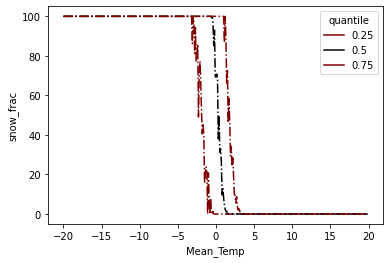

In [48]:
sns.lineplot(data=qdf, x="Mean_Temp", y="snow_frac", hue='quantile', palette=['maroon','black','maroon'], linestyle='dashdot') 

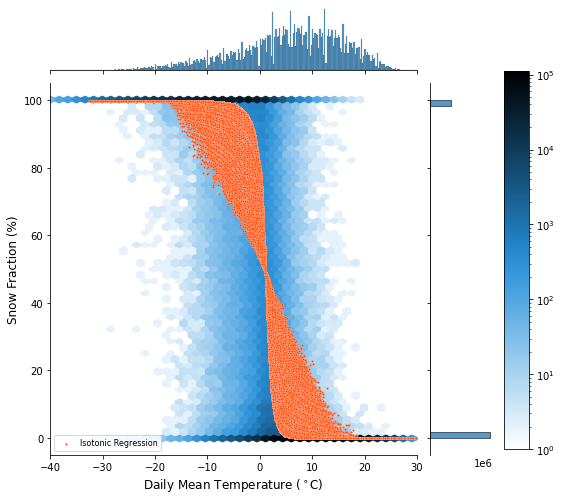

In [241]:
plt.rcParams["axes.labelsize"] = 12
g = sns.jointplot(
    x=merged_df['Mean_Temp'], 
    y=merged_df['snow_frac']*100, 
    kind='hex', 
    bins='log', 
    height=7
)
# sns.scatterplot(
#     x=merged_df["Mean_Temp"],
#     y=[i*100 for i in preds_log],
#     ax=g.ax_joint,
#     s=0.7,
#     color='r',
#     label="Generalized Logistic"
# )
sns.scatterplot(
    x=merged_df["Mean_Temp"],
    y=[i*100 for i in preds_iso],
    ax=g.ax_joint,
    s=5,
    color='orangered',
    label="Isotonic Regression"
)
# sns.lineplot(
#     data=qdf, 
#     x="Mean_Temp", 
#     y="snow_frac", 
#     hue='quantile', 
#     palette=['maroon','black','maroon'], 
#     linestyle='--', 
#     ax=g.ax_joint, 
#     linewidth=2
# )
# sns.lineplot(
#     x_lr, 
#     Heaviside(x_lr, -50, thresh, -1), 
#     color='g', 
#     linewidth=2.5, 
#     label='Heaviside (AHCCD)', 
#     ax=g.ax_joint
# )
# sns.lineplot(
#     x_lr, 
#     Heaviside(x_lr, -50, t2m_thresh, -1), 
#     color='g', 
#     linewidth=2.5, 
#     label='Heaviside (ERA5-Land)', 
#     ax=g.ax_joint
# )
# sns.lineplot(
#     x=x_lr, 
#     y=(logistic4(x_lr, *params_log))*100, 
#     color='#ffcc00', 
#     label= 'Generalized Logistic (AHCCD)', 
#     ax=g.ax_joint, 
#     linewidth=2.5
# )
# sns.lineplot(
#     x=x_lr, 
#     y=(logistic4(x_lr, *params_era5))*100, 
#     color='#ffcc00', 
#     label= 'Generalized Logistic (ERA5-Land)', 
#     ax=g.ax_joint, 
#     linewidth=2.5
# )
# sns.lineplot(
#     x=x_lr, 
#     y=[i*100 for i in yy_ir], 
#     color='red', 
#     label= 'Isotonic Regression(AHCCD)', 
#     ax=g.ax_joint, 
#     linewidth=2.5
# )
# sns.lineplot(
#     x=x_lr, 
#     y=[i*100 for i in yy_ir_era5], 
#     color='red', 
#     label= 'Isotonic Regression (ERA5-Land)', 
#     ax=g.ax_joint, 
#     linewidth=2.5
# )
g.ax_joint.legend(prop={"size": 8}, loc='lower left')
g.ax_joint.set(xlabel='Daily Mean Temperature ($^\circ$C)', ylabel='Snow Fraction (%)', xlim=(-40, 30))
cbar_ax = g.fig.add_axes([1, .1, .05, .75])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.savefig('Mean_Temp_monthly.png')

In [ ]:
plt.bar(np.arange(1, 10,1 ))